HaRe
====

HaRe (Harassment Recognizer) is a command line tool and Python library to automatically detect harassment as it happens (real-time) with the help of machine learning techniques. In this notebook we will look at the Python library.

Basic usage: monitoring conversations
--------------------------------------------------------

The easiest way to use HaRe is by simply loading a pretrained HaRe model. You can load it by simply doing:

In [1]:
from hare import load_pretrained
moba_hare = load_pretrained('hare/pretrained/moba')

You can then use this object to monitor conversations in progress. Let's start a conversation and ask HaRe to monitor it:

In [2]:
from hare import Conversation

convo = Conversation()
moba_hare.add_conversation(convo)

You can add utterances to this conversation as they become available, and at any point in time, you can then request the current status of the conversation according to this HaRe model:

In [3]:
convo.add_utterance(speaker='a',content='hello')
convo.add_utterance(speaker='b',content='hi everyone')
moba_hare.get_status()

{'a': 0.008861654438078403, 'b': 0.005346317775547504}

You can also add multiple sentences at once (for example a whole conversation if it has already finished), and see what HaRe's best guess was at every moment in time.

In [4]:
from hare import Utterance

convo.add_utterances([Utterance(speaker='a',content='good luck'),
                      Utterance(speaker='c',content='noob team'),
                      Utterance(speaker='c',content='u guys suck'),
                      Utterance(speaker='b',content='ur a loser yourself'),
                      Utterance(speaker='a',content='take it easy guys'),
                      Utterance(speaker='c',content='noob')])

moba_hare.visualize_history_for_conversation()

a: hello
{'a': 0.008861654438078403}
---

b: hi everyone
{'a': 0.008861654438078403, 'b': 0.005346317775547504}
---

a: good luck
{'a': 0.010540383867919445, 'b': 0.005346317775547504}
---

c: noob team
{'a': 0.010540383867919445, 'b': 0.005346317775547504, 'c': 0.07421243190765381}
---

c: u guys suck
{'a': 0.010540383867919445, 'b': 0.005346317775547504, 'c': 0.5076202750205994}
---

b: ur a loser yourself
{'a': 0.010540383867919445, 'b': 0.010474762879312038, 'c': 0.5076202750205994}
---

a: take it easy guys
{'a': 0.012263094075024128, 'b': 0.010474762879312038, 'c': 0.5076202750205994}
---

c: noob
{'a': 0.012263094075024128, 'b': 0.010474762879312038, 'c': 0.5150563716888428}
---



Or in a graph:

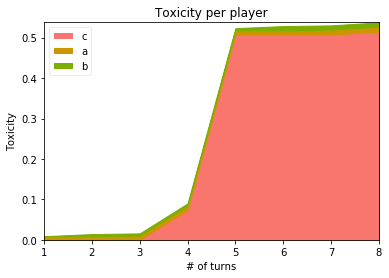

In [5]:
%matplotlib inline

from hare.visualize import visualize_toxicity_for_one_conversation
    
visualize_toxicity_for_one_conversation(moba_hare)

If you add multiple conversations for Hare to monitor, you will need to specify the conversation index when asking for the status:

In [6]:
second_convo = Conversation()

second_convo.add_utterance(speaker='a',content='hello')
second_convo.add_utterance(speaker='b',content='hi everyone')
second_convo.add_utterance(speaker='a',content='go away loser!')

moba_hare.add_conversation(second_convo)
moba_hare.get_status(id=1)

{'a': 0.017604785040020943, 'b': 0.005346317775547504}

Evaluating 
----------
If you have a labeled dataset (that is: for each conversation an indication which participants are considered toxic), HaRe can calculate to what extent its judgments match the labels. The labels can either be the default 0 (not toxic) or 1 (maximally toxic). Labeling speaker c in the first conversation above would look like this:

In [7]:
convo.label_speaker('c',1)

There are several evaluation metrics, depending on what is important to you (detecting ALL harassment, detecting harassment quickly, no false positives, etc). You can ask a HaRe object to output these aggregate scores directly, but we can also visualize them similar to how we visualized the estimates for a single conversation above. You can use these metrics to find out which HaRe object suits your goals best. 

Let's do an experiment. Besides the default machine-learning based engine, called a 'brain' in the HaRe framework, it's also possible to simply detect toxicity based on a wordlist using a so-called `DictBasedBrain`. Below we take a pretrained machine-learning based classifier (named `moba_hare`), and compare it with two Hare objects using such a `DictBasedBrain` (named `insult_hare` and `swear_hare`).

In [8]:
from hare import Hare
from hare.brain import DictBasedBrain

moba_hare = load_pretrained('hare/pretrained/moba')
moba_hare.name = 'machine-learning'

insult_hare = Hare(name='insults')
insult_hare.brain = DictBasedBrain()
insult_hare.brain.bad_words = ['noob','newb','n00b','fag','loser']

swear_hare = Hare(name='swear_words')
swear_hare.brain = DictBasedBrain()
swear_hare.brain.bad_words = ['fuck','fck','fuk','shit','stfu','wtf','suck']

HaRe comes with 8 fictional example conversations that are typical for a videogame environment. Let's give these to our three Hare objects to monitor.

In [9]:
from hare import load_example_conversations

example_conversations = load_example_conversations()
print('Loaded',len(example_conversations),'conversations')

for conversation in example_conversations:
    insult_hare.add_conversation(conversation)
    swear_hare.add_conversation(conversation)
    moba_hare.add_conversation(conversation)

Loaded 8 conversations


Now we have multiple labeled conversations and HaRe objects to analyze them, let's visualize the evaluation measure 'Area under the (ROC) Curve' to see how they perform. An AUC of 0.5 means that the HaRe object is performing at chance level, an AUC of 1 means that it's perfect.

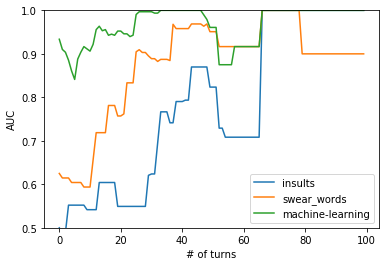

In [10]:
%matplotlib inline

from hare.visualize import visualize_accuracy_during_conversations, visualize_auc_during_conversations, visualize_fscore_during_conversations

visualize_auc_during_conversations([insult_hare,swear_hare,moba_hare])

We see that the estimates are poor in the beginning of conversations, when there is almost no information, and that this gradually gets better as more people speak. The machine learning generally identifies the toxic player earlier in the conversation, but the word list model, in particular the one with swear words, picks up later. Also note that scores can decrease again over time, as a system might get confused with utterances at a later point in the conversation.

In the graph above, a player is 'identified' as toxic if it has an toxicity estimate above 0.5 . Of course, you can play with this: if you set this threshold to a lower value, there will be more positives (true positives, but also false positives), and if you set it to a higher value, there will be more negatives (true negatives, but also false negatives). 

Instead of visualizing a score over time, we can also visualize the score with various of these thresholds. The  the ROC curve and the precision/recall graph are two common ways of doing this. In the first graph below, lines closer to the upper left corner are better, and in the second graph lines closer to the upper right corner are better. 

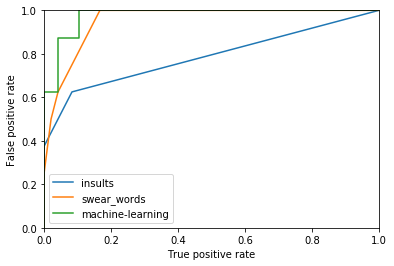

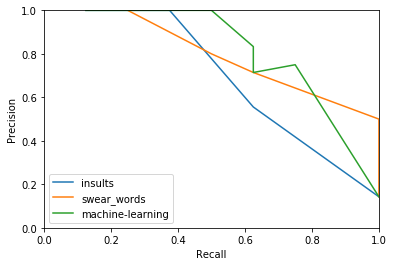

In [11]:
%matplotlib inline

from hare.visualize import visualize_retrospective_precision_and_recall, visualize_retrospective_roc_curve

visualize_retrospective_roc_curve([insult_hare,swear_hare,moba_hare])
visualize_retrospective_precision_and_recall([insult_hare,swear_hare,moba_hare])

Zooming in on the performance of the machine learning based Hare (the green line) in the precision/recall graph: we see that we can set the toxity threshold really high so we have no false positives, but then we find only 50% of the toxic players (precision 1, recall 0.5)... or we can set the threshold really low so we find all of them, but then 20% are true positives (precision 0.2, recall 1). The optimal threshold seems to have both values are 80%: 80% of toxic players detected, 80% is a true positive.

Training
=======

If the existing pretrained models do not score high enough on your conversations, and you have data where the toxic speakers are labeled, you can train your own models. Before you can do this, you need to select a 'brain', which is the classification algorithm HaRe will use under the hood. At the time of writing, neural networks with Bidirectional Gated Recurrent Units are popular for text classification, so we will use the `BiGruBrain`. This 'brain' uses the implementation in TensorFlow.

In [12]:
from hare import Hare
from hare.bigrubrain import BiGruBrain

custom_hare = Hare()
custom_hare.brain = BiGruBrain()

An interesting option for BiGruBrains (and potentially others) is that they allow you to add word embeddings, which you can see as general knowledge on the meaning of words, collected from large amounts of texts (like Wikipedia).

In [13]:
custom_hare.brain.embedding_location = '/vol/bigdata/word_embeddings/glove/glove.6B.50d.txt' #This is the path of the embeddings where this notebook was run

Now, all we need to do is add the conversation we want to train on, and we're ready to start training.

In [14]:
custom_hare.add_conversation(convo)
custom_hare.add_conversation(second_convo)

custom_hare.train()
custom_hare.save('name_of_folder')

Epoch 1/3
5/5 [==============================] - 3s 591ms/step - loss: 0.7564 - acc: 0.2000
Epoch 2/3
5/5 [==============================] - 0s 15ms/step - loss: 0.6060 - acc: 0.8000
Epoch 3/3
5/5 [==============================] - 0s 13ms/step - loss: 0.5112 - acc: 0.8000


And that's all there is to it! If you want to reuse the Hare object later, you can save it and put it in the `pretrained` folder, so you can reload it with the `load_pretrained` function later.